In [1]:
import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')

from sparse_rrt import _deep_smp_module
# from params.cpp_dst_s32_e4 import get_params

def experiment_vis(env_id, traj_id, verbose=False, system='cartpole_obs', params=None, ax=None, bx=None, number_of_iterations=1, planner=None):
   
    solution = planner.get_solution()

    data_cost = np.sum(data['cost'])
#     th = 1.2 * data_cost
    ## start experiment
    tic = time.perf_counter()
    min_dist = np.inf
    
    for iteration in tqdm(range(number_of_iterations)):
        # planner.step(min_time_steps, max_time_steps, params['dt'])
        if params['hybrid']:
            if np.random.rand() < params['hybrid_p']:
                planner.step(min_time_steps, max_time_steps, integration_step)
            else:
                states = planner.neural_step(params['refine'], 
                        refine_threshold=params['refine_threshold'],
                        using_one_step_cost=params['using_one_step_cost'],
                        cost_reselection=params['cost_reselection'],
                        goal_bias=params['goal_bias'])
                if np.linalg.norm(states[4:7]) > 0:
                    ax.scatter(states[0], states[2], color='blue', )
                    ax.scatter(states[4], states[6], color='green',)
                    ax.scatter(states[8], states[10], color='pink', alpha=0.1)
                    ax.plot([states[0], states[4]], [states[2], states[6]], color='skyblue')
                    ax.plot([states[0], states[8]], [states[2], states[10]], color='pink', alpha=0.1)
                    
                    bx.scatter(states[1], states[3], color='blue', )
                    bx.scatter(states[5], states[7], color='green',)
                    bx.scatter(states[9], states[11], color='pink',alpha=0.1)
                    bx.plot([states[1], states[5]], [states[3], states[7]], color='skyblue')
                    bx.plot([states[1], states[9]], [states[3], states[11]], color='pink',alpha=0.1)

        else:
            # planner.step(min_time_steps, max_time_steps, integration_step)
            states = planner.neural_step(params['refine'], 
                    refine_threshold=params['refine_threshold'],
                    using_one_step_cost=params['using_one_step_cost'],
                    cost_reselection=params['cost_reselection'],
                    goal_bias=params['goal_bias'])
#             print(states[4:], ref_path[-1])
            angle_err = np.abs(states[6]-ref_path[-1][2])
            angle_err = 2 * np.pi - angle_err if angle_err > np.pi else angle_err
            dist = np.sqrt(np.sum((states[[4,5,7]]-ref_path[-1][[0,1,3]]) ** 2 + angle_err ** 2))
            if dist < min_dist:
                print(dist)
                min_dist = dist
            if dist < 5:
                params['goal_bias'] = 0.4
                
            if np.linalg.norm(states[4:7]) > 0:
                ax.scatter(states[0], states[2], color='blue', )
                ax.scatter(states[4], states[6], color='green',)
                ax.scatter(states[8], states[10], color='pink',)
                ax.plot([states[0], states[4]], [states[2], states[6]], color='skyblue')
                ax.plot([states[0], states[8]], [states[2], states[10]], color='pink')

                bx.scatter(states[1], states[3], color='blue', )
                bx.scatter(states[5], states[7], color='green',)
                bx.scatter(states[9], states[11], color='pink',)
                bx.plot([states[1], states[5]], [states[3], states[7]], color='skyblue')
#                 bx.plot([states[1], states[9]], [states[3], states[11]], color='pink')
        # planner.mpc_step(integration_step)
        solution = planner.get_solution()
        if solution is not None: #and np.sum(solution[2]) < th:
            break

    toc = time.perf_counter()
    if solution is not None:
        print(solution[0], solution[2])
#     print(mpc_mpnet.costs)
    costs = solution[2].sum() if solution is not None else np.inf
    result = {
        'env_id': env_id,
        'traj_id': traj_id,
        'planning_time': toc-tic,
        'successful': solution is not None,
        'costs': costs,
        'solution': solution,
    }
    
    print("\t{}, time: {} seconds, {}(ref:{}) costs".format(
            result['successful'],
            result['planning_time'],
            result['costs'],
            np.sum(data['cost'])))
    return result
    

def full_benchmark(num_env, num_traj, save=True, config='default', report=True, params_module=None, system='acrobot_obs', traj_id_offset=800):
    sr = np.zeros((num_env, num_traj))
    time = np.zeros((num_env, num_traj))
    costs = np.zeros((num_env, num_traj))

    for env_id in range(num_env):
        for traj_id in range(num_traj):
            result = experiment(env_id, traj_id + traj_id_offset, params_module=params_module, system=system)
            sr[env_id, traj_id] = result['successful']
            if result['successful']:
                time[env_id, traj_id] = result['planning_time']
                costs[env_id, traj_id] = result['costs']
            if save:
                Path("results/cpp_full/{}/{}/".format(config, system)).mkdir(parents=True, exist_ok=True)
                np.save('results/cpp_full/{}/{}/sr_{}_{}.npy'.format(config, system, num_env, num_traj), sr)
                np.save('results/cpp_full/{}/{}/time_{}_{}.npy'.format(config, system, num_env, num_traj), time)
                np.save('results/cpp_full/{}/{}/costs_{}_{}.npy'.format(config, system,  num_env, num_traj), costs)
            if report:
                print("sr:{}\ttime:{}\tcosts:{}".format(
                    sr.reshape(-1)[:(num_traj*env_id+traj_id+1)].mean(),
                    time.reshape(-1)[:(num_traj*env_id+traj_id+1)].mean(),
                    costs.reshape(-1)[:(num_traj*env_id+traj_id+1)].mean(),
                    ))
# /home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/neural_test_visualization_mpnet.py


def draw_obs(env_id, system, ax=None):
    def line_line_cc(x1, y1, x2, y2, x3, y3, x4, y4):
        uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
        uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
        if uA >= 0. and uA <= 1. and uB >= 0. and uB <= 1.:
            # intersection
            return True
        # collision free
        return False
    def IsInCollision(x, obc, obc_width=4.):
        I = 10
        L = 2.5
        M = 10
        m = 5
        g = 9.8
        H = 0.5

        STATE_X = 0
        STATE_V = 1
        STATE_THETA = 2
        STATE_W = 3
        CONTROL_A = 0

        MIN_X = -30
        MAX_X = 30
        MIN_V = -40
        MAX_V = 40
        MIN_W = -2
        MAX_W = 2


        if x[0] < MIN_X or x[0] > MAX_X:
            return True

        H = 0.5
        pole_x1 = x[0]
        pole_y1 = H
        pole_x2 = x[0] + L * np.sin(x[2])
        pole_y2 = H + L * np.cos(x[2])

        width = 4
        for i in range(len(obc)):
            for j in range(0, 8, 2):
                x1 = obc[i][j]
                y1 = obc[i][j+1]
                x2 = obc[i][(j+2) % 8]
                y2 = obc[i][(j+3) % 8]
                if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                    return True
        return False
    _obs_list = get_obs(system, env_id)[env_id]#.reshape(-1, 2)
    obs_list = []
    width = 4
    for i in range(len(_obs_list)):
        x = _obs_list[i][0];
        y = _obs_list[i][1];
        obs = np.zeros(8)
        obs[0] = x - width / 2;  obs[1] = y + width / 2;
        obs[2] = x + width / 2;  obs[3] = y + width / 2;
        obs[4] = x + width / 2;  obs[5] = y - width / 2;
        obs[6] = x - width / 2;  obs[7] = y - width / 2;
        obs_list.append(obs)
    obs_i = np.array(obs_list)
        
#     print(obs_i)

    dx = 1
    dtheta = 0.1
    feasible_points = []
    infeasible_points = []
    imin = 0
    imax = int(2*30./dx)
    jmin = 0
    jmax = int(2*np.pi/dtheta)

    for i in range(imin, imax):
        for j in range(jmin, jmax):
            x = np.array([dx*i-30, 0., dtheta*j-np.pi, 0.])
            if IsInCollision(x, obs_i):
                infeasible_points.append(x)
            else:
                feasible_points.append(x)
    feasible_points = np.array(feasible_points)
    infeasible_points = np.array(infeasible_points)
    # print('feasible points')
    # print(feasible_points)
    # print('infeasible points')
    # print(infeasible_points)
    ax.scatter(feasible_points[:,0], feasible_points[:,2], c='azure')
    ax.scatter(infeasible_points[:,0], infeasible_points[:,2], c='slategray')


<ipython-input-1-c8b7e86bd767>:133: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
<ipython-input-1-c8b7e86bd767>:134: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


env 0, traj 1801


40.56716593083421
39.78972182418986
39.31987077895542
39.12597271492041
38.97734308900407
38.42218642724763
38.31465113651271
38.10607885906688
38.00937921657411
37.88714049050415
34.63146016705653
34.41235346285226
33.76258725869602
33.62034353912205
33.225947340057836
33.17790183517446
32.04778232491004
17.79929754138152
8.510315622064535
5.343093005745107

	False, time: 22.28302321396768 seconds, inf(ref:9.652000000000001) costs


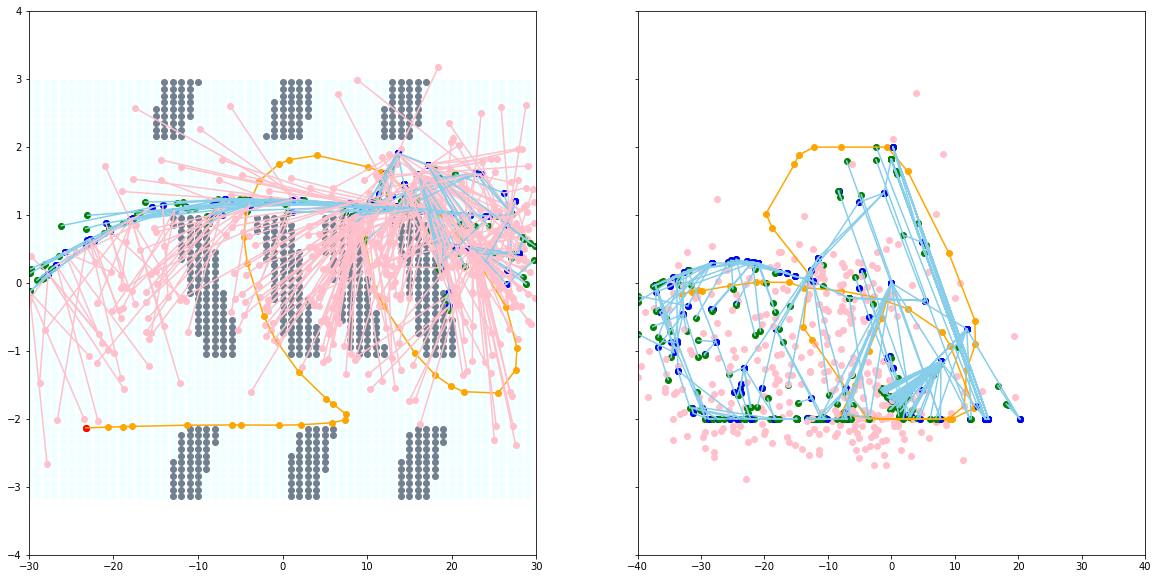

In [2]:
# %matplotlib notebook
%matplotlib inline

env_id = 0
traj_id = 1801
system = 'cartpole_obs'
config = 'default'

from matplotlib import pyplot as plt

params = {
        'n_sample': 32,
        'n_elite': 4,
        'n_t': 1,
        'max_it': 3,
        'converge_r': 1e-1,
        
        'dt': 2e-3,

        'mu_u': 0,
        'sigma_u': 400,

        #'mu_t': 0.1,
        #'sigma_t': 0.3,
        #'t_max': 1,
        'mu_t': 0.4,
        'sigma_t': 0.5,
        't_max': 0.6,

        'verbose': True,# False,#
        'step_size': 0.8,

        "goal_radius": 1.5,

        "sst_delta_near": 0.1,
        "sst_delta_drain": 0.05,
        "goal_bias": 0.,

        "width": 4,
        "hybrid": False,#True,# 
        "hybrid_p": 0.,
        
        "min_time_steps": 10,
        "max_time_steps": 200,
    
        "cost_samples": 10,
#         "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_pos_vel_external.pt",
#         "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v3_multigoal.pt",
        #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v2_deep.pt",
#         "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k.pt",
        #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_branch.pt",
        "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_small_model.pt",
    
        # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_nonorm.pt",
        # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_subsample0.5_10k.pt",

        "cost_predictor_weight_path": "mpnet/exported/output/cartpole_obs/cost_10k.pt",
        "cost_to_go_predictor_weight_path": "mpnet/exported/output/cartpole_obs/cost_to_go_10k.pt",

        "refine": False,
        "using_one_step_cost": False,
        "refine_lr": 0,
        "refine_threshold": 0,
        "device_id": "cuda:0",

        "cost_reselection": False,
        "number_of_iterations": 1000,
        "weights_array": [1.0, 0.5, 1, 0.5],

    }
fig, (ax, bx) = plt.subplots(1, 2, sharey=True, figsize=(20,10))
draw_obs(env_id, system, ax)


print("env {}, traj {}".format(env_id, traj_id))
obs_list = get_obs(system, env_id)[env_id].reshape(-1, 2)
data = load_data(system, env_id, traj_id)
ref_path = data['path']
start_goal = data['start_goal']
# print(start_goal)
env_vox = np.load('mpnet/sst_envs/{}_env_vox.npy'.format(system))
obc = env_vox[env_id, 0]
# print(obs_list)
params = params
#number_of_iterations = params['number_of_iterations'] #3000000# 
min_time_steps = params['min_time_steps'] if 'min_time_steps' in params else 80
max_time_steps = params['max_time_steps'] if 'min_time_steps' in params else 400
integration_step = params['dt']

ax.scatter(ref_path[0][0], ref_path[0][2], color='orange')
ax.scatter(ref_path[-1][0], ref_path[-1][2], color='red')

planner = _deep_smp_module.DSSTMPCWrapper(
        system,
        start_state=np.array(ref_path[0]),
        goal_state=np.array(start_goal[-1]),
#             goal_state=np.array(data['start_goal'][-1]),
        goal_radius=params['goal_radius'],
        random_seed=0,
        sst_delta_near=params['sst_delta_near'],
        sst_delta_drain=params['sst_delta_drain'],
        obs_list=obs_list,
        width=params['width'],
        verbose=params['verbose'],
        mpnet_weight_path=params['mpnet_weight_path'], 
        cost_predictor_weight_path=params['cost_predictor_weight_path'],
        cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
        num_sample=params['cost_samples'],
        ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
        converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
        std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
        device_id=params['device_id'], refine_lr=params['refine_lr'],
        weights_array=params['weights_array'],
        obs_voxel_array=obc.reshape(-1)
    )



data = load_data(system, env_id, traj_id)
ref_path = data['path']


ax.set_xlim(-30, 30)
ax.set_ylim(-3.14, 3.14)

bx.set_xlim(-40, 40)
bx.set_ylim(-4, 4)



ax.scatter(ref_path[:, 0], ref_path[:, 2], color='orange')
ax.plot(ref_path[:, 0], ref_path[:, 2], color='orange')

ax.scatter(ref_path[0, 0], ref_path[0, 2], color='cyan')
ax.scatter(ref_path[-1, 0], ref_path[-1, 2], color='red')

bx.scatter(ref_path[:, 1], ref_path[:, 3], color='orange')
bx.plot(ref_path[:, 1], ref_path[:, 3], color='orange')

result = experiment_vis(env_id, 
                        traj_id, 
                        verbose=False, 
                        system='cartpole_obs', 
                        params=params, 
                        ax=ax, 
                        bx=bx,
                        number_of_iterations=params['number_of_iterations'],
                        planner=planner)

In [3]:
path = result['solution'][0]

ax.scatter(path[:, 0], path[:, 2], color='red')
ax.plot(path[:, 0], path[:, 2], color='red')


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# %matplotlib inline

# fig, (ax, bx) = plt.subplots(1, 2, sharey=True, figsize=(20,10))
# draw_obs(env_id, system, ax)
# ax.set_xlim(-30, 30)
# ax.set_ylim(-3.14, 3.14)

# bx.set_xlim(-40, 40)
# bx.set_ylim(-4, 4)



# ax.scatter(ref_path[:, 0], ref_path[:, 2], color='orange')
# ax.plot(ref_path[:, 0], ref_path[:, 2], color='orange')

# ax.scatter(ref_path[0, 0], ref_path[0, 2], color='cyan')
# ax.scatter(ref_path[-1, 0], ref_path[-1, 2], color='red')

# bx.scatter(ref_path[:, 1], ref_path[:, 3], color='orange')
# bx.plot(ref_path[:, 1], ref_path[:, 3], color='orange')
# result = experiment_vis(env_id, 
#                         traj_id, 
#                         verbose=False, 
#                         system='cartpole_obs', 
#                         params=params, 
#                         ax=ax, 
#                         bx=bx,
#                         number_of_iterations=params['number_of_iterations'],
#                         planner=planner)
# plt.show()